In [84]:
import sys
import math
import collections
import itertools
import dendropy
import numpy
from dendropy.calculate import probability
from dendropy.utility import GLOBAL_RNG
from dendropy.utility.error import TreeSimTotalExtinctionException
from dendropy.utility import constants
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import cProfile
import random


In [87]:
def new_bd_tree(birth_rate, death_rate, cov, **kwargs):
    """
    Returns a birth-death tree with birth rate specified by ``birth_rate``, and
    death rate specified by ``death_rate``, with edge lengths in discrete (integer)
    units.
    
    Tree growth is controlled by one or more of the following arguments, of which
    at least one must be specified:

        - If ``ntax`` is given as a keyword argument, tree is grown until the number of
         tips == ntax.
        - If ``taxon_namespace`` is given as a keyword argument, tree is grown until the
         number of tips == len(taxon_namespace), and the taxa are assigned randomly to the
         tips.
        - If 'max_time' is given as a keyword argument, tree is grown for ``max_time``
         number of generations.

    If more than one of the above is given, then tree growth will terminate when
    *any* of the termination conditions (i.e., number of tips == ``ntax``, or number
    of tips == len(taxon_namespace) or number of generations = ``max_time``) are met.

    Also accepts a Tree object (with valid branch lengths) as an argument passed
    using the keyword ``tree``: if given, then this tree will be used; otherwise
    a new one will be created.

    If ``assign_taxa`` is False, then taxa will *not* be assigned to the tips;
    otherwise (default), taxa will be assigned. If ``taxon_namespace`` is given
    (``tree.taxon_namespace``, if ``tree`` is given), and the final number of tips on the
    tree after the termination condition is reached is less then the number of
    taxa in ``taxon_namespace`` (as will be the case, for example, when
    ``ntax`` < len(``taxon_namespace``)), then a random subset of taxa in ``taxon_namespace`` will
    be assigned to the tips of tree. If the number of tips is more than the number
    of taxa in the ``taxon_namespace``, new Taxon objects will be created and added
    to the ``taxon_namespace`` if the keyword argument ``create_required_taxa`` is not given as
    False.

    Under some conditions, it is possible for all lineages on a tree to go extinct.
    In this case, if the keyword argument ``repeat_until_success`` is |True|, then a new
    branching process is initiated.
    If |False| (default), then a TreeSimTotalExtinctionException is raised.

    A Random() object or equivalent can be passed using the ``rng`` keyword;
    otherwise GLOBAL_RNG is used.
    """
    birth_vector = []
    death_vector = []
    time_vector = []
    birth_samps = []
    death_samps = []
    prog_statement1 = "Simulation "
    prog_statement2 = "% Completed: "
    prog_statement3 = " Taxa at Present.......Generation "
    birth_flag1 = "Treewide Probability of Birth ="
    birth_flag2 = "at generation"
    death_flag1 = "Treewide Probability of Death ="
    death_flag2 = "at generation"
    #final_node_births = []
    #final_node_deaths = []
    if 'ntax' not in kwargs \
        and 'taxon_namespace' not in kwargs \
        and 'max_time' not in kwargs:
            raise ValueErarror("At least one of the following must be specified: 'ntax', 'taxon_namespace', or 'max_time'")
    target_num_taxa = None
    taxon_namespace = None
    target_num_gens = kwargs.get('max_time', None)
    #death_change, birth_change = numpy.random.multivariate_normal(mean=[0,0], cov=cov,size = target_num_gens).T
    if 'taxon_namespace' in kwargs:
        taxon_namespace = kwargs.get('taxon_namespace')
        target_num_taxa = kwargs.get('ntax', len(taxon_namespace))
    elif 'ntax' in kwargs:
        target_num_taxa = kwargs['ntax']
    if taxon_namespace is None:
        taxon_namespace = dendropy.TaxonNamespace()
    repeat_until_success = kwargs.get('repeat_until_success', False)
    rng = kwargs.get('rng', GLOBAL_RNG)
    progress_vector = numpy.around(numpy.linspace(0, target_num_gens, num=100), 0)

##############################################################################################
##################### This is where we want to start editing our function ####################
##############################################################################################
   # grow tree
    if "tree" in kwargs:
        tree = kwargs['tree']
        if "taxon_namespace" in kwargs and kwargs['taxon_namespace'] is not tree.taxon_namespace:
            raise ValueError("Cannot specify both ``tree`` and ``taxon_namespace``") #
    else:
        tree = dendropy.Tree(taxon_namespace=taxon_namespace) #Create empty tree, assign it an empty namespace - initializing
        tree.is_rooted = True
        tree.seed_node.edge.length = 0
        tree.seed_node.birth_rate = birth_rate # Assigns initial birth rate
        tree.seed_node.death_rate = death_rate # Assigns initial death rate
    leaf_nodes = tree.leaf_nodes() # Assigning empy nodes
    num_gens = 0 # Start at generation 
    while (target_num_taxa is None or len(leaf_nodes) < target_num_taxa) \
           and (target_num_gens is None or num_gens < target_num_gens):
        # Instantiate rate vectors
        total_birth = []
        total_death = []
        # Now loop through and append to vectors node by node
        for nd in leaf_nodes: 
            if not hasattr(nd, 'birth_rate'): #If any new leaves without set properties, assign to original rates -
                nd.birth_rate = birth_rate    #Need to change so that new daughter leaves are exact copies of parents
            if not hasattr(nd, 'death_rate'): #Consider changing to birth_rate + rng_gauss
                nd.death_rate = death_rate
            try:
                nd.edge.length += 1 # Try to add one (generation), if you can't because it's equal to none
            except TypeError:
                nd.edge.length = 1
            total_birth = numpy.append(total_birth, nd.birth_rate)
            total_death = numpy.append(total_death, nd.death_rate)

        # Now create cumulative sum
        total_birth_cumsum = numpy.cumsum(total_birth)
        total_death_cumsum = numpy.cumsum(total_death)
        # Now rescale to between zero and one
        birth_cumsum_rescale = total_birth_cumsum / total_birth_cumsum.max(axis=0)
        death_cumsum_rescale = total_death_cumsum / total_death_cumsum.max(axis=0)
        
        # Now draw a random uniform deviate
        the_decider = numpy.random.uniform(low=0, high=1,size=1)
         
        # Determine the node of the individual for which the event will happen
        birth_winner = next(x[0] for x in enumerate(birth_cumsum_rescale) if x[1] > the_decider)
        death_winner = next(x[0] for x in enumerate(death_cumsum_rescale) if x[1] > the_decider)
              
        birth_wait = numpy.random.exponential(scale=1/total_birth[birth_winner])
        death_wait = numpy.random.exponential(scale=1/total_death[death_winner])
        
        #winning_event = min(birth_wait, death_wait) 

        #if winning_event == birth_wait:
        #    winner = birth_winner
        #elif winning_event == death_wait:
        #    winner = death_winner
        
        #if winning_event < 1 and winning_event == birth_wait: # according to an exponential waiting time
        if cov == [[0, 0],[0, 0]]:
            birth_winner = random.choice(numpy.arange(len(tree.leaf_nodes())))
            death_winner = random.choice(numpy.arange(len(tree.leaf_nodes())))
        #for nd in leaf_nodes:    
        if birth_wait < 1 and birth_wait < death_wait:
            nd = tree.leaf_nodes()[birth_winner]
            birth_parent = nd.birth_rate
            death_parent = nd.death_rate
            c1 = nd.new_child()
            c2 = nd.new_child()            
            c1.edge.length = 0
            c2.edge.length = 0
            c1.birth_rate = birth_parent
            c1.death_rate = death_parent
            c2.birth_rate = birth_parent
            c2.death_rate = death_parent
        #if winning_event < 1 and winning_event == death_wait:
        if death_wait < 1 and death_wait < birth_wait:
            #nd = tree.leaf_nodes()[death_winner]
            if nd is not tree.seed_node:
                    tree.prune_subtree(nd)
            elif not repeat_until_success:
                # all lineages are extinct: raise exception
                raise TreeSimTotalExtinctionException()
            else:
                print "all lineages are extinct: repeat"
                num_gens = 0
        num_gens += 1
        leaf_nodes = tree.leaf_nodes()
        
        # Now go through and evolve rates along all currently existing branches
        death_change, birth_change = numpy.random.multivariate_normal(mean=[0,0], cov=cov, size=len(leaf_nodes)).T 
        counter = 0
        for nd in leaf_nodes: 
            nd.birth_rate = nd.birth_rate + birth_change[counter]
            if nd.birth_rate <= 0:
                nd.birth_rate = 1e-25  
            #birth_samps = numpy.append(birth_samps,nd.birth_rate)
            nd.death_rate = nd.death_rate + death_change[counter]
            if nd.death_rate <= 0:
                nd.death_rate = 1e-25 
            #death_samps = numpy.append(death_samps,nd.death_rate)
            counter = counter + 1
            
        #for nd in leaf_nodes: 
        #    birth_vector = numpy.append(birth_vector, nd.birth_rate)
        #    death_vector = numpy.append(death_vector, nd.death_rate)
        #    time_vector = numpy.append(time_vector, num_gens)
        if num_gens in progress_vector:
            print (prog_statement1 + str(numpy.around(((num_gens/target_num_gens)*100),0)) + 
                   prog_statement2 + str(len(leaf_nodes)) + prog_statement3 + str(num_gens))
            #if total_birth_cumsum[-1] > 0.01:
                #print(birth_flag1 + str(total_birth_cumsum[-1]) + birth_flag2 + str(num_gens))
            #if total_death_cumsum[-1] > 0.01:
                #print(death_flag1 + str(total_death_cumsum[-1]) + death_flag2 + str(num_gens))
        
        if kwargs.get("ntax", True):
            gens_to_add = 0
            if target_num_taxa == len(leaf_nodes):
                gens_to_add += 1
                for nd in leaf_nodes: 
                    nd.edge.length += gens_to_add
            
              
            
            
        #for nd in tree.leaf_nodes():
        #    nd.edge.length += 1
    gens_to_add = 0
        
    # If termination condition specified by ntax or taxon_namespace, then the last
    # split will have a daughter edges of length == 0;
    # so we continue growing the edges until the next birth/death event *or*
    # the max number of generations condition is given and met
    #while (target_num_gens is None or num_gens < target_num_gens):
    #    u = rng.uniform(0, 1)
    #    if u < (birth_rate + death_rate):
    #        break
    #    gens_to_add += 1
    #for nd in tree.leaf_nodes():
    #    nd.edge.length += gens_to_add

    if kwargs.get("assign_taxa", True):
            tree.randomly_assign_taxa(create_required_taxa=True, rng=rng)    
    #return (tree, birth_vector, death_vector, time_vector)
    return (tree, num_gens, leaf_nodes)


In [98]:
sim_tree = new_bd_tree(birth_rate=4e-3, death_rate=3.75e-3, cov=[[0, 0],[0, 0]], 
                       max_time=1000000, ntax = 200, repeat_until_success=True)

all lineages are extinct: repeat
all lineages are extinct: repeat
all lineages are extinct: repeat
all lineages are extinct: repeat
all lineages are extinct: repeat
all lineages are extinct: repeat
all lineages are extinct: repeat
all lineages are extinct: repeat
Simulation 1.0% Completed: 11 Taxa at Present.......Generation 10101
Simulation 2.0% Completed: 17 Taxa at Present.......Generation 20202
Simulation 3.0% Completed: 14 Taxa at Present.......Generation 30303
Simulation 4.0% Completed: 25 Taxa at Present.......Generation 40404
Simulation 5.0% Completed: 18 Taxa at Present.......Generation 50505
Simulation 6.0% Completed: 22 Taxa at Present.......Generation 60606
Simulation 7.0% Completed: 12 Taxa at Present.......Generation 70707
Simulation 8.0% Completed: 21 Taxa at Present.......Generation 80808
Simulation 9.0% Completed: 18 Taxa at Present.......Generation 90909
Simulation 10.0% Completed: 22 Taxa at Present.......Generation 101010
Simulation 11.0% Completed: 18 Taxa at Prese

In [90]:
sim_tree[0].print_plot()

                                                 /------------------------ T1  
                                                 |                             
                                                 |         /-------------- T2  
                                            /----+    /----+                   
                                            |    |    |    |    /--------- T3  
                                            |    |    |    \----+              
                                            |    |    |         |    /---- T4  
                                            |    \----+         \----+         
                                            |         |              \---- T5  
                   /------------------------+         |                        
                   |                        |         |              /---- T6  
                   |                        |         \--------------+         
                   |                    

In [25]:
# Returns distance of node furthest from root, i.e., maximum time available on
# tree
total_time = sim_tree[0].max_distance_from_root()

# Divide time span into 10 steps
step = float(total_time) / 10

# To store tuples of (time, number of lineages)
ltt = []

# Start at first time step
current_time = step
while current_time <= total_time:
    # Get number of lineages at current time
    num_lineages = sim_tree[0].num_lineages_at(current_time)
    # Store it
    ltt.append( (current_time, num_lineages) )
    # Move to next time step
    current_time += step

# Get the final number of lineages
# Note: may not be the same as the number of tips if the tree has extinct
# tips/taxa; though, if this were the case, we would not be dealing with an
# ultrametric tree.
if current_time < total_time:
    ltt.append( (total_time, sim_tree[0].num_lineages_at(total_time)) )

# Print results
for t, num_lineages in ltt:
    print("{:12.8f}\t{}".format(t, num_lineages))

80458.00000000	6
160916.00000000	11
241374.00000000	18
321832.00000000	28
402290.00000000	39
482748.00000000	48
563206.00000000	63
643664.00000000	77
724122.00000000	100
804580.00000000	128


In [99]:
sim_tree[0].write(path='output_constRate2.tre', schema = "newick")

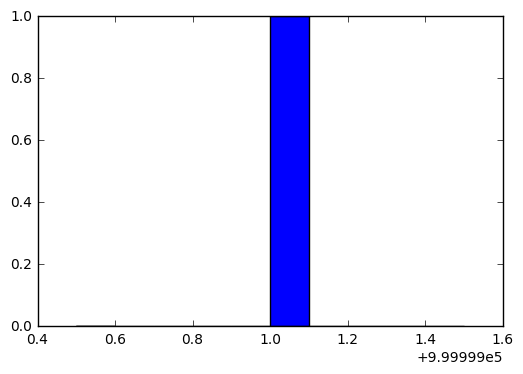

In [202]:
plt.hist(sim_tree[1])
plt.show()

In [50]:
cov=[[0,0],[0,0]]
cov

[[0, 0], [0, 0]]

In [203]:
plt.hist(sim_tree[2])
plt.show()

TypeError: unsupported operand type(s) for +: 'Node' and 'float'

In [ ]:
import seaborn as sns
plot = sns.regplot(sim_tree[3], sim_tree[2], fit_reg=False, scatter_kws={'s':0.1})
plot.figure.set_size_inches(10.5, 10.5)

plt.xlim(0, 30000)
plt.show()
sim_tree[2]

In [ ]:
import seaborn as sns
plot = sns.regplot(sim_tree[3], sim_tree[1], fit_reg=False, scatter_kws={'s':0.1})
plot.figure.set_size_inches(10.5, 10.5)
plt.xlim(0, 30000)
plt.show()
sim_tree[3]

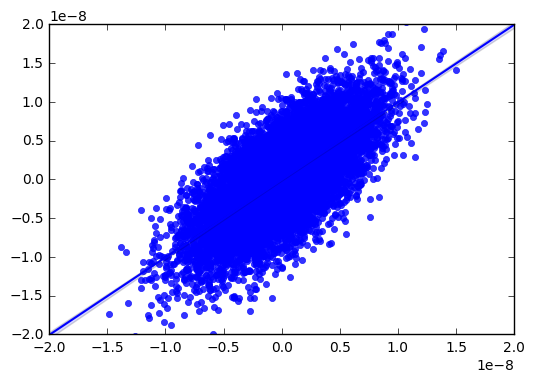

In [19]:
cov=[[2.08333e-17, 3.1e-17],[0, 1.08333e-17]]
mean=[0,0]
x,y = numpy.random.multivariate_normal(mean=mean, cov=cov,size = 10000).T
import seaborn as sns
sns.regplot(x,y)
plt.ylim(-0.00000002, 0.00000002)
plt.xlim(-0.00000002, 0.00000002)
plt.show()

In [ ]:
2.08333e-25*6000000